In [1]:
# ZANIM ZACZNIEMY MUSIMY ZAINSTALOWAĆ PYDANTIC, BYĆ MOŻE BĘDZIEMY MUSIELI ZROBIĆ RESTART KERNELA
!pip install --quiet instructor pydantic openai

In [2]:
import json # żeby pracować z jsonem
from pathlib import Path # żeby móc tworzyć ścieżki
from datetime import date # żeby niektóre zz pól wyciągniętych z obrazków były widoczne jako daty
import base64 # transformowanie obrazków na format który akceptuje OpenAI
from getpass import getpass # umożliwia w ramach notenooka przekazywać hasła (sekrety), których nie chemy żeby były widoczne dla innych

from IPython.display import Image # pozwala wyświetlać obrazki w notbooku
import instructor
from pydantic import BaseModel
from openai import OpenAI
import pandas as pd

In [3]:
openai_key = getpass("Wprowadź swój klucz OpenAI: ")

Wprowadź swój klucz OpenAI:  ········


In [4]:
openai_client = OpenAI(api_key=openai_key)

# Pracujemy z plikami - PDF / Obrazek / Zrzut ekranu

## ZANIM ZACZNIEMY

* Pod video załączone są linki do kilku rachunków za gaz w formacie `.png`.
* Pobierz te pliki.
* Następnie utwórz folder `dane_gaz`
* A w nim foldery `raw` i `processed`
* W folderze `raw` umieść pobrane rachunki

In [5]:
RAW_DATA_PATH = Path("dane_benzyna") / "raw"

PROCESSED_DATA_PATH = Path("dane_benzyna") / "processed"

In [6]:
for image_path in RAW_DATA_PATH.glob("*.jpeg"):
    print(image_path)

dane_benzyna/raw/D9919C2F-A3D9-4EBF-8950-B145389DE90D_1_105_c.jpeg
dane_benzyna/raw/6B8ADEBA-44E4-48AF-BAB8-9F4ECCB4EC93.jpeg
dane_benzyna/raw/40F84B21-85F5-4717-8F8F-2F0DC13484B9_4_5005_c.jpeg
dane_benzyna/raw/D1DDDCFE-C292-4E63-8653-47510E5B8FE1_1_105_c.jpeg
dane_benzyna/raw/50BE279B-0943-4C36-9089-B60A39FA3A32.jpeg


## Przykładowy rachunek

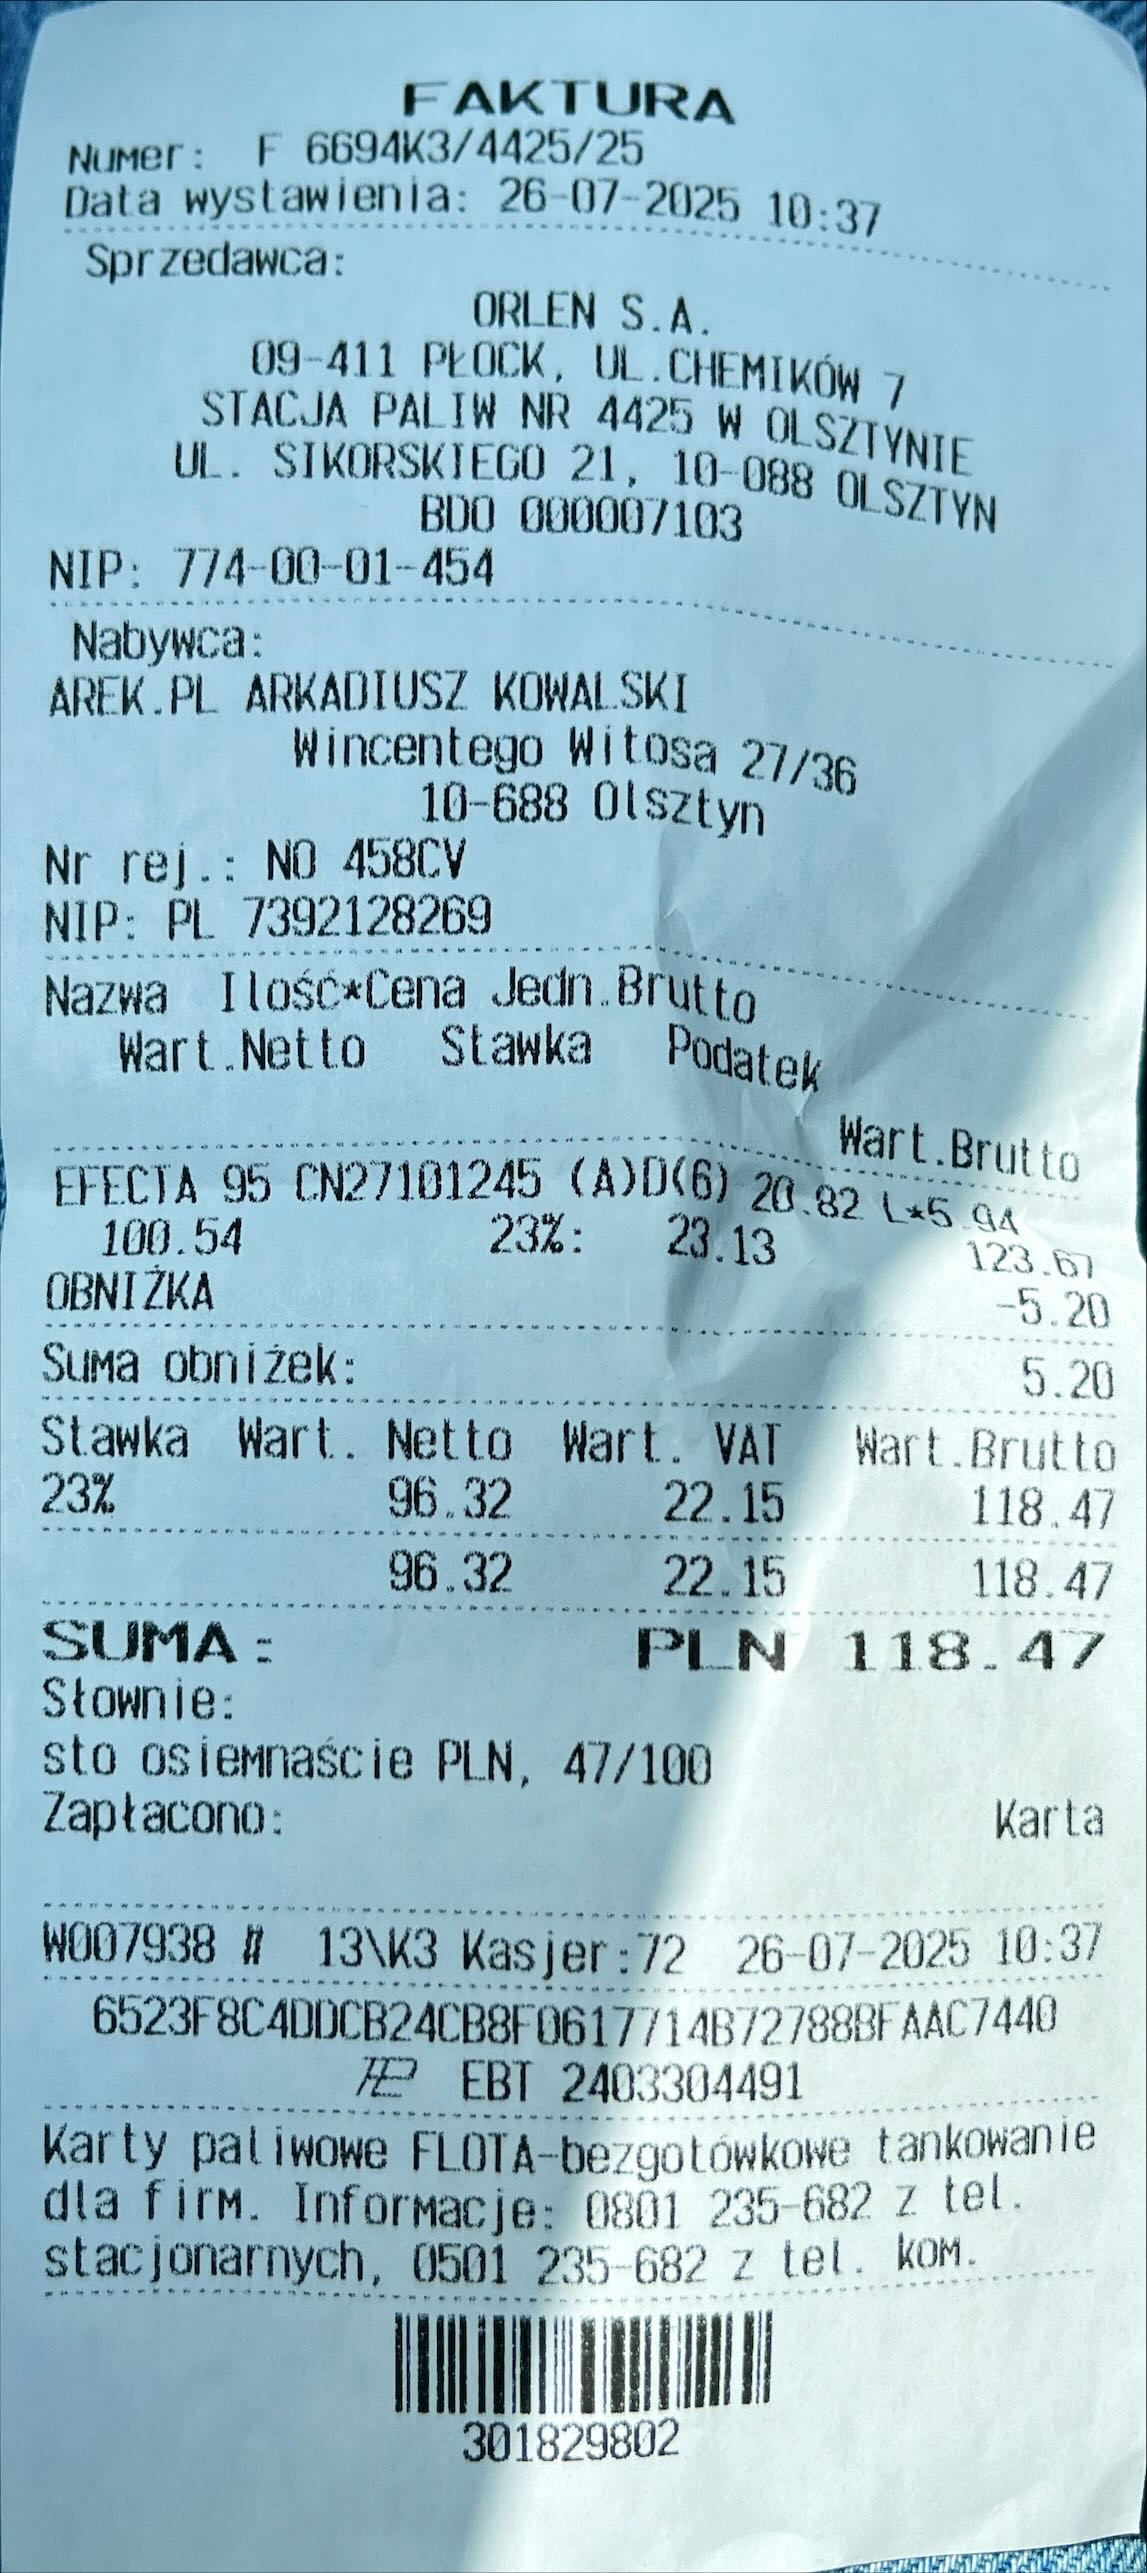

In [7]:
Image(RAW_DATA_PATH / "6B8ADEBA-44E4-48AF-BAB8-9F4ECCB4EC93.jpeg")

## Przygotowanie obrazków do przesłania do OpenAI

In [12]:
image_path = RAW_DATA_PATH / "6B8ADEBA-44E4-48AF-BAB8-9F4ECCB4EC93.jpeg"

with open(image_path, "rb") as f: # otwiera plik w trybie czytania bajtów
    image_data = base64.b64encode(f.read()).decode('utf-8') # i zapisuje
 
image_data[:100]

'/9j/4AAQSkZJRgABAQAASABIAAD/4R0SRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAA'

In [13]:
def prepare_image_for_open_ai(image_path):
    with open(image_path, "rb") as f:
        image_data = base64.b64encode(f.read()).decode('utf-8')

    return f"data:image/jpeg;base64,{image_data}"

## Wyciągamy dane przy pomocy OpenAI

In [14]:
image_path = RAW_DATA_PATH / "6B8ADEBA-44E4-48AF-BAB8-9F4ECCB4EC93.jpeg"

response = openai_client.chat.completions.create(
    # model="gpt-4o",
    model="gpt-4o-mini",
    temperature=0, #żeby model nie był zbyt "nieprzewidywalny"
    # poniżej jest wiadomość tekstowa do chata, co ma wyciągnąć i w jakiej postaci
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": """
wyciągnij wszystkie informacje zawarte na fakturze.
Dane przedstaw w formacie JSON.
Oczekuję następujących informacji:
{
"Data_wystawienia": ...,
"Effecta_95_litry": ...,
"cena_za_litr_l*": ...,
"SUMA_PLN": ...,
}
tylko dane jako JSON, bez żadnych komentarzy
"""
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": prepare_image_for_open_ai(image_path),
                        "detail": "high"
                    },
                },
            ],
        }
    ],
)

# {
# "razem_sprzedaż_okres_rozliczeniowy_data_od": "01.12.2023",
# "razem_sprzedaż_okres_rozliczeniowy_data_do": "31.12.2023",
# "zużycie_m3": 130,
# "zużycie_kWh": 1505,
# "do_zapłaty": "463,55 zł",
# "termin_płatności": "18.12.2023"
# }
print(response.choices[0].message.content)

```json
{
  "Data_wystawienia": "26-07-2025",
  "Effecta_95_litry": "20.82",
  "cena_za_litr_l*": "5.94",
  "SUMA_PLN": "118.47"
}
```


In [15]:
for image_path in RAW_DATA_PATH.glob("*.jpeg"): # tu tworzymy pętlę
    print(f"Processing {image_path}")

    response = openai_client.chat.completions.create(
        model="gpt-4o",
        # model="gpt-4o-mini",
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": """
wyciągnij wszystkie informacje zawarte na fakturze.
Dane przedstaw w formacie JSON.
Oczekuję następujących informacji:
{
"Data_wystawienia": ...,
"Effecta_95_litry": ...,
"cena_za_litr_l*": ...,
"SUMA_PLN": ...,
}
tylko dane jako JSON, bez żadnych komentarzy
"""
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": prepare_image_for_open_ai(image_path),
                            "detail": "high"
                        },
                    },
                ],
            }
        ],
    )

    result = response.choices[0].message.content.replace("```json", "").replace("```", "").strip()
    with open(PROCESSED_DATA_PATH / f"{image_path.stem}__simple.json", "w") as f:
        f.write(result)

Processing dane_benzyna/raw/D9919C2F-A3D9-4EBF-8950-B145389DE90D_1_105_c.jpeg
Processing dane_benzyna/raw/6B8ADEBA-44E4-48AF-BAB8-9F4ECCB4EC93.jpeg
Processing dane_benzyna/raw/40F84B21-85F5-4717-8F8F-2F0DC13484B9_4_5005_c.jpeg
Processing dane_benzyna/raw/D1DDDCFE-C292-4E63-8653-47510E5B8FE1_1_105_c.jpeg
Processing dane_benzyna/raw/50BE279B-0943-4C36-9089-B60A39FA3A32.jpeg


## Wyciągamy dane z pliku PDF przy pomocy OpenAI + instructor

In [16]:
class GasBillInfo(BaseModel): #tu definiujemy klasę jak mają być przedstawione te dane
    Data_wystawienia: date
    Effecta_95_litry: float
    cena_za_litr_l: float
    SUMA_PLN: float

instructor_openai_client = instructor.from_openai(OpenAI(api_key=openai_key))

In [17]:
image_path = RAW_DATA_PATH / "6B8ADEBA-44E4-48AF-BAB8-9F4ECCB4EC93.jpeg"

gas_bill = instructor_openai_client.chat.completions.create(
    model="gpt-4o",
    response_model=GasBillInfo, #tu przekazujemy wg jakiej struktury ma wyciągnąć dane z obrazka
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Pobierz szczegóły rachunku za gaz",
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": prepare_image_for_open_ai(image_path),
                        "detail": "high"
                    },
                },
            ],
        },
    ],
)

gas_bill

GasBillInfo(Data_wystawienia=datetime.date(2025, 7, 26), Effecta_95_litry=20.82, cena_za_litr_l=5.94, SUMA_PLN=118.47)

In [18]:
for image_path in RAW_DATA_PATH.glob("*.jpeg"):
    print(f"Processing {image_path}")

    gas_bill = instructor_openai_client.chat.completions.create(
        model="gpt-4o",
        response_model=GasBillInfo,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Pobierz szczegóły rachunku za gaz",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": prepare_image_for_open_ai(image_path),
                            "detail": "high"
                        },
                    },
                ],
            },
        ],
    )
    with open(PROCESSED_DATA_PATH / f"{image_path.stem}.json", "w") as f:
        f.write(gas_bill.model_dump_json())


Processing dane_benzyna/raw/D9919C2F-A3D9-4EBF-8950-B145389DE90D_1_105_c.jpeg
Processing dane_benzyna/raw/6B8ADEBA-44E4-48AF-BAB8-9F4ECCB4EC93.jpeg
Processing dane_benzyna/raw/40F84B21-85F5-4717-8F8F-2F0DC13484B9_4_5005_c.jpeg
Processing dane_benzyna/raw/D1DDDCFE-C292-4E63-8653-47510E5B8FE1_1_105_c.jpeg
Processing dane_benzyna/raw/50BE279B-0943-4C36-9089-B60A39FA3A32.jpeg


In [19]:
# wczytajmy wszystkie dane
data = []
for json_path in PROCESSED_DATA_PATH.glob("*.json"):
    if "simple" in json_path.name:
        continue 
        
    with open(json_path) as f:
        data.append(json.loads(f.read()))

df = pd.DataFrame(data)
df

,Data_wystawienia,Effecta_95_litry,cena_za_litr_l,SUMA_PLN
0,2025-07-26,20.82,5.94,118.47
1,2025-08-16,27.01,5.79,149.97
2,2025-04-04,22.08,5.95,131.38
3,2025-08-24,27.60,5.79,152.90
4,2025-07-05,22.27,5.99,127.83


<Axes: xlabel='SUMA_PLN'>

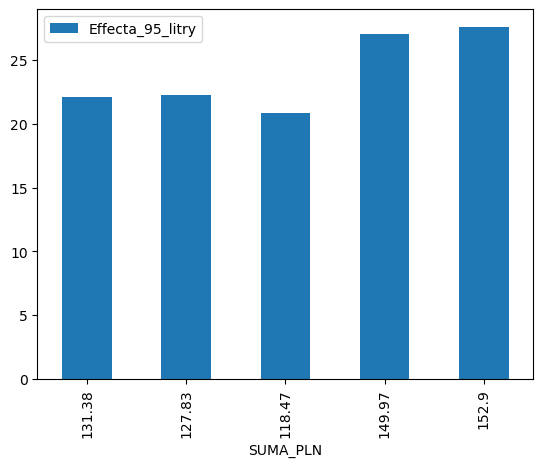

In [22]:
df.sort_values("Data_wystawienia").plot(x="SUMA_PLN", y="Effecta_95_litry", kind="bar")